# Reconocimiento facial - Caso Práctico 2

## Problemas:
Se tiene problemas para instalar en entornos linux y windows la libreria face-recognition, para que funcione en windows....

In [ ]:
#instalación de librerías necesarias 
%pip install face-recognition
%pip install opencv-contrib-python  #Adición de módulos avanzados para manejo de objetos y reconocimiento
%pip install tabulate

## Paso 1.- Extracción de rostros para entrenamiento posterior del modelo

In [31]:
#Importar módulos necesarios
import cv2  #Manejo de imagenes
import os   #Manejo de archivos/directorios
import face_recognition         # Linreria de reconocimiento facial 
from datetime import datetime   # Para el registro de fecha y hora de asistencia
from tabulate import tabulate   #Tabulación de resultados de aistencia

import imghdr  #Para validar si un archivo es imagen
import sys     #Manejo de comandos de S.O. 
import matplotlib.pyplot as plt   #Para gráficos

In [32]:
#Constantes a usar
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [34]:
#Definición de funciones necesarias
#Evalua si un archivo es imagen válida
def isImage(filePath):
    return imghdr.what(filePath) is not None

#Evalua existencia de directorios
def existsDirectory(directoryPath):
    return os.path.exists(directoryPath) and os.path.isdir(directoryPath)

#Visualizasión de mensajes 
def message(text, color):
    print(f"{color}{text}{RESET}")

#Registro de Asistencias
def attendanceRegister(student):
    if student!='Desconocido':
        for registro in attendance:
            # Verificar si el estudiante ya está registrado
            if registro['nombre'] == student:
                ##message(f"{student} ya está registrado.",RED)
                return
        hora_registro = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        registro = {'nombre': student, 'hora': hora_registro}
        attendance.append(registro)

def printReport():
    tabla_asistencia = [[record['nombre'], record['hora']] for record in attendance]
    message("\nRegistros de asistencia:".center(100),BLUE)
    print(tabulate(tabla_asistencia, headers=["Nombre del Estudiante", "Hora de Registro"]))

Inicio Proceso de reconocimiento de rostros en imagenes.
Procesando archivo foto3.jpg


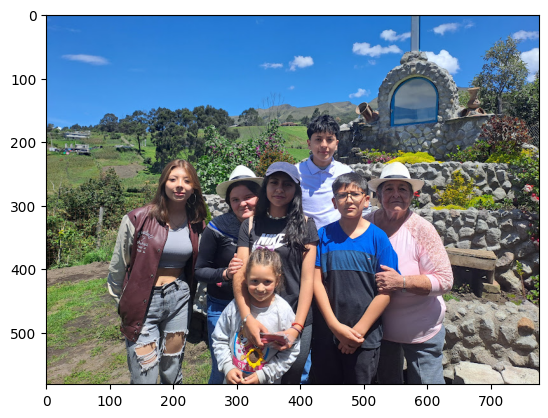

Procesando archivo IMG20231.jpg


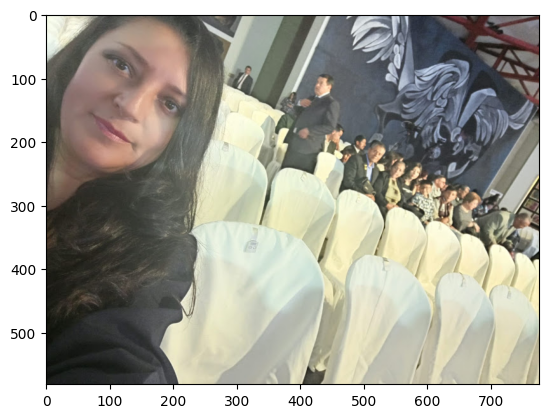

Procesando archivo proyectoErick.docx
Archivo proyectoErick.docx no es imagen
Procesando archivo 238.jpg


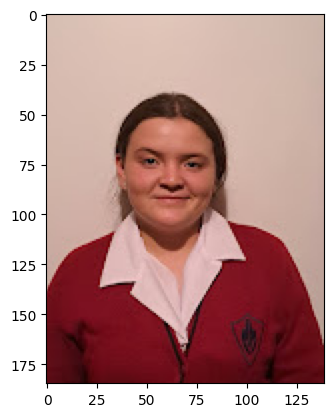

Procesando archivo foto.png


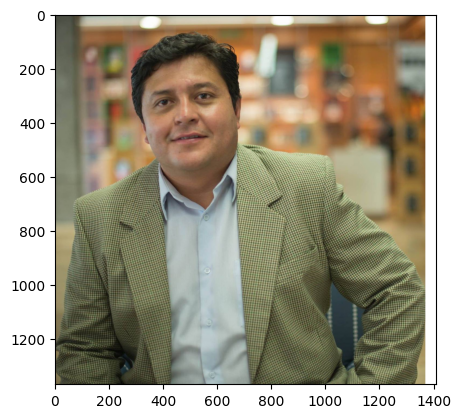

Procesando archivo WA0007.jpg


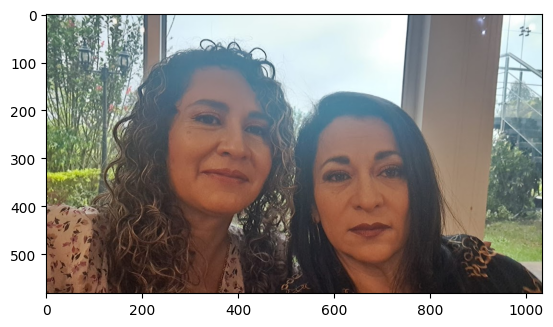

In [35]:
# Reconocimiento y alamacenamiento de rostros de imagenes aleatorias

sourceImages = "sourceImages"  #Directorio que almacena imagenes que contienen rostros para manejo  posterior
facesRepo    = "facesRepo"     #Direcorio donde se almacenaran los rostros 

#Existe directorio que contiene imagenes fuente?
message("Inicio Proceso de reconocimiento de rostros en imagenes.", GREEN)
if not existsDirectory(sourceImages):    
    message("Repositorio de imagenes fuente no existe",RED)
    message("PROCESAMIENTO TERMINADO",RED)
    sys.exit()

#Existe directorio contenedore de rostros?
if not existsDirectory(facesRepo):   
    os.makedirs(facesRepo)
    message("Se crea carpeta contenedora de rostros.", GREEN)

#Inicio delproceso
faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Modelo detector de rostros
i = 0

for imageName in os.listdir(sourceImages):
    message("Procesando archivo "+imageName, GREEN)
    if not isImage(sourceImages + "/" + imageName):
        message("Archivo "+imageName+ " no es imagen",RED)
    else:
        #Carga la imagen a memoria
        image = cv2.imread(sourceImages + "/" + imageName)
        
        #Visualizar imagen a procesar
        imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(imgRGB)
        plt.show()
        
        faces = faceClassif.detectMultiScale(image, 1.1, 5)
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face = image[y:y + h, x:x + w]
            face = cv2.resize(face, (150, 150))
            cv2.imwrite(facesRepo + "/" + str(i) + ".jpg", face)
            i += 1
            ###cv2.imshow("Rostros", face)
            ###cv2.waitKey(0)
        cv2.imshow("Image", image)
        ###cv2.waitKey(0)
    cv2.destroyAllWindows()

## Paso 2.- Reconocer Rostros en tiempo real

In [36]:
#Guardar embeding nombres y registros asistencia
facesEncodings = []
facesNames = []
attendance = []

In [38]:
#Bucle para obtener los codigos de codificacion facial de los rostros almacenados
for face in os.listdir(facesRepo):
    image = cv2.imread(facesRepo + "/" + face)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    f_coding = face_recognition.face_encodings(image, known_face_locations=[(0, 150, 150, 0)])[0]
    facesEncodings.append(f_coding)
    facesNames.append(face.split(".")[0])
###message("Embeding de los rostros", GREEN)
###print(facesEncodings)
###message("Nombres de rostros a buscar", GREEN)
###print(facesNames)

#Lectura del video 
##stream = cv2.VideoCapture(0, cv2.CAP_DSHOW) backen para windows
stream = cv2.VideoCapture(0,cv2.CAP_V4L2)  #backend para captura de video recomentdado para linux

#Modelo para la detección Facial
faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

#Bucle de captura del video hasta presionar escape
while True:
    ret, frame = stream.read() 
    
    if ret == False:   #Evaluar la lectura del frame desde el video
        message("Error al leer el video",RED)
        print(ret)
        break
    
    #Voltea el frame horizontalmente para efecto espejo
    frame = cv2.flip(frame, 1) 
    
    orig = frame.copy()
    
    #Búsqueda de rostros en el frame
    faces = faceClassif.detectMultiScale(frame, 1.1, 5)
    
    #Proceso de recuadro y etiqueta de los rostros
    # Itera sobre cada rostro detectado
    for (x, y, w, h) in faces:
        # Extrae la región de interés (el rostro) del frame original
        face = orig[y:y + h, x:x + w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        
        #obtener los codigos de codificacion facial de los rostros almacenados
        actual_face_encoding = face_recognition.face_encodings(face, known_face_locations=[(0, w, h, 0)])[0]
        
        #Compara y busca similitudes en los rostros
        result = face_recognition.compare_faces(facesEncodings, actual_face_encoding)
        
        if True in result:
            index = result.index(True)
            name = facesNames[index]
            color = (125, 220, 0)
            ##message("Registrar asistencia para "+name, GREEN)
            ###attendanceRegister(name)
        else:
            name = "Desconocido"
            color = (50, 50, 255)
        #recuadro y etiqueta del rostro detectado
        cv2.rectangle(frame, (x, y + h), (x + w, y + h + 30), color, -1)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, name, (x, y + h + 25), 2, 1, (255, 255, 255), 2, cv2.LINE_AA)
        ##message("Registrar asistencia para "+name, GREEN)
        attendanceRegister(name)

    cv2.imshow("Frame", frame)
    
    k = cv2.waitKey(1) & 0xFF
    if k == 27:  #tecla escape
        break
stream.release()
cv2.destroyAllWindows()
printReport()

                                     
Registros de asistencia:                                      
Nombre del Estudiante    Hora de Registro
-----------------------  -------------------
Wilfrido                 2024-06-22 19:02:28
Anahi                    2024-06-22 19:02:33
Adrian                   2024-06-22 20:27:08
Irene                    2024-06-22 20:28:01
Leandro                  2024-06-22 20:28:03
Mayte                    2024-06-22 20:28:09
Iveth                    2024-06-22 20:28:25
Micaela                  2024-06-22 20:28:26
